In [39]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [40]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [41]:
root_captioning = "D:\\datasets\\image_caption_data"

In [42]:

null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
    max_length = 0
    for line in fp.read().split('\n'):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split('.')[0]
            desc = tok[1:]
      # Cleanup description
            desc = [word.lower() for word in desc]
            desc = [w.translate(null_punct) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            max_length = max(max_length,len(desc))
            if id not in lookup:
                lookup[id] = list()
            lookup[id].append(' '.join(desc))
lex = set()
for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]

In [43]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [44]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [45]:
len(img)

8091

In [46]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
    f = os.path.split(i)[-1]
    if f in train_images: 
        train_img.append(f) 
    elif f in test_images:
        test_img.append(f)

In [47]:
print(len(train_images))
print(len(test_images))

6000
1000


In [48]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'

In [49]:
len(train_descriptions)

6000

In [50]:
if USE_INCEPTION:
    encode_model = InceptionV3(weights='imagenet')
    encode_model = Model(encode_model.input, encode_model.layers[-2].output)
    WIDTH = 299
    HEIGHT = 299
    OUTPUT_DIM = 2048
    preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
    encode_model = MobileNet(weights='imagenet',include_top=False)
    WIDTH = 224
    HEIGHT = 224
    OUTPUT_DIM = 50176
    preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

In [51]:
encode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

__________________________________________________________________________________________________
batch_normalization_v1_113 (Bat (None, 35, 35, 64)   192         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_115 (Bat (None, 35, 35, 64)   192         conv2d_115[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_118 (Bat (None, 35, 35, 96)   288         conv2d_118[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_119 (Bat (None, 35, 35, 64)   192         conv2d_119[0][0]                 
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 35, 35, 64)   0           batch_normalization_v1_113[0][0] 
__________

__________________________________________________________________________________________________
batch_normalization_v1_134 (Bat (None, 17, 17, 192)  576         conv2d_134[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_137 (Bat (None, 17, 17, 192)  576         conv2d_137[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_142 (Bat (None, 17, 17, 192)  576         conv2d_142[0][0]                 
__________________________________________________________________________________________________
batch_normalization_v1_143 (Bat (None, 17, 17, 192)  576         conv2d_143[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 17, 17, 192)  0           batch_normalization_v1_134[0][0] 
__________

batch_normalization_v1_167 (Bat (None, 17, 17, 192)  576         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 17, 17, 192)  0           batch_normalization_v1_167[0][0] 
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 17, 17, 192)  258048      activation_167[0][0]             
__________________________________________________________________________________________________
batch_normalization_v1_164 (Bat (None, 17, 17, 192)  576         conv2d_164[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_3[0][0]              
                                                                 activation_187[0][0]             
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [52]:

# serialize weights to HDF5
encode_model.save_weights("image_caption_model.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
def encodeImage(img):
    # Resize all images to a standard size (specified bythe image encoding network)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
    x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
    x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
    x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
    x = np.reshape(x, OUTPUT_DIM )
    return x

In [54]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
    start = time()
    encoding_train = {}
    for id in tqdm(train_img):
        image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
        img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_train[id] = encodeImage(img)
    with open(train_path, "wb") as fp:
        pickle.dump(encoding_train, fp)
    print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
    with open(train_path, "rb") as fp:
        encoding_train = pickle.load(fp)

In [55]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
    start = time()
    encoding_test = {}
    for id in tqdm(test_img):
        image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
        img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_test[id] = encodeImage(img)
    with open(test_path, "wb") as fp:
        pickle.dump(encoding_test, fp)
    print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
    with open(test_path, "rb") as fp:
        encoding_test = pickle.load(fp)

In [56]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [57]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [81]:
#test_path = os.path.join(root_captioning,"data",f'Vocab.pkl')
#with open(test_path, "wb") as fp:
 #   print("yes")
  #  pickle.dump(vocab, fp)
#print(vocab)

yes
['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tricolored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'ears', 'rope', 'net', 'red', 'climbs', 'bridge', 'onto', 'ropes', 'playground', 'running', 'grassy', 'garden', 'surrounded', 'fence', 't

In [58]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [59]:
max_length +=2
print(max_length)

34


In [60]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
            for desc in desc_list:
            # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n=0

In [61]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:24, 16327.65it/s]


Found 400000 word vectors.


In [62]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [79]:
#test_path = os.path.join(root_captioning,"data",f'embedding_matrix.pkl')
#with open(test_path, "wb") as fp:
#    pickle.dump(embedding_matrix, fp)
print(embedding_matrix)
embedding_matrix.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.49340001 -0.0085568  -0.4605     ... -0.55435002 -0.57477999
  -0.013045  ]
 ...
 [-0.021736    0.15308     0.11436    ...  0.078342   -0.39166999
   0.12937   ]
 [ 0.20298    -0.10048    -0.33627    ...  0.40496999 -0.19888
  -0.10866   ]
 [ 0.41156    -0.25863001  0.016209   ... -0.25419    -0.27496001
   0.67840999]]


(1652, 200)

In [64]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [76]:
print(embedding_dim)

200


In [66]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 

In [67]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [68]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [69]:
EPOCHS = 3
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS*2)):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 6
    steps = len(train_descriptions)//number_pics_per_bath

    for i in range(EPOCHS):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
    caption_model.save_weights(model_path)
    #print(f"\Training took: {hms_string(time()-start)}")
else:
    caption_model.load_weights(model_path)

In [70]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

D:\datasets\image_caption_data\Flicker8k_Dataset\136644343_0e2b423829.jpg


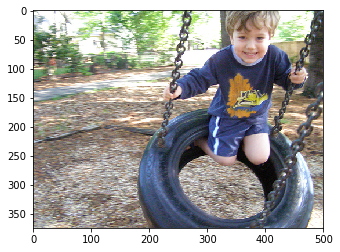

Caption: boy in red shirt is swinging on swing
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\136886677_6026c622eb.jpg


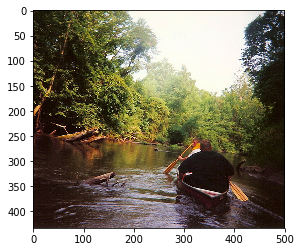

Caption: man in red kayak is paddling through river
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1386964743_9e80d96b05.jpg


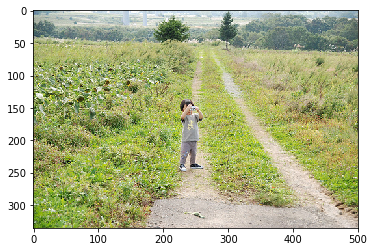

Caption: two people are sitting on rock by the water
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\138718600_f430ebca17.jpg


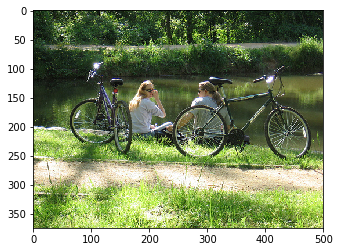

Caption: man in red shirt is riding bike down the street
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1387785218_cee67735f5.jpg


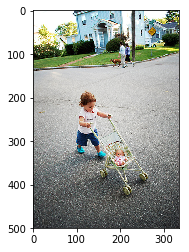

Caption: little boy is walking on the grass
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1389264266_8170bc1c54.jpg


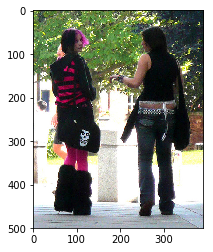

Caption: two women in traditional clothes are standing in front of store
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1392272228_cf104086e6.jpg


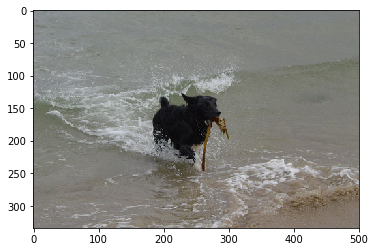

Caption: black dog is running through the water
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1394368714_3bc7c19969.jpg


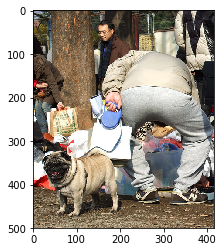

Caption: man in blue shirt is sitting on the ground looking at the camera
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1402640441_81978e32a9.jpg


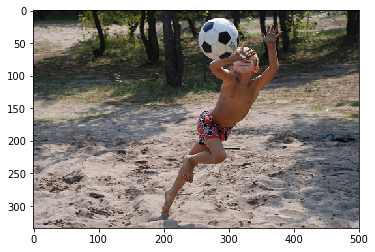

Caption: two boys are playing soccer on the beach
_____________________________________
D:\datasets\image_caption_data\Flicker8k_Dataset\1404832008_68e432665b.jpg


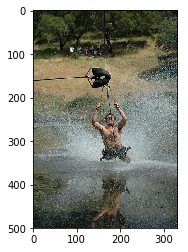

Caption: man in wetsuit is surfing in the water
_____________________________________


In [71]:
for z in range(41,51):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
    x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
    plt.imshow(x)
    plt.show()
    print("Caption:",generateCaption(image))
    print("_____________________________________")

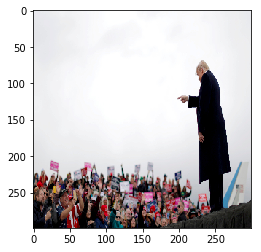

Caption: group of people are standing around fire
_____________________________________


In [72]:
image_path = "D:\\datasets\\image_caption_data\\test4.jpg"
img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
pic = encodeImage(img)
image = pic.reshape((1,OUTPUT_DIM))
plt.imshow(img)
plt.show()
print("Caption:",generateCaption(image))
print("_____________________________________")